# Mood/Vibe Classification for Music Recommendations

This notebook implements a deep learning classifier to categorize music tracks by mood/vibe categories (happy, sad, energetic, calm, focus). The model is trained on Spotify audio features and can be used for contextual music recommendations.

### Objective

Classify music tracks into mood/vibe categories (happy, sad, energetic, calm, focus) using Spotify audio features. This classification enables contextual music recommendations and playlist curation based on listener mood preferences.

**Key Deliverables**:
- Trained deep learning model for mood prediction
- Feature preprocessing pipeline (StandardScaler)
- Model artifacts for production deployment
- Evaluation metrics and performance analysis


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## 1. Setup and Imports

Import required libraries for data processing, PyTorch model training, and evaluation metrics.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you saved the file in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'


# Load the CSV file into a pandas DataFrame
spotify_df = pd.read_csv(drive_path + '/spotify.csv')

# Display the first few rows to verify
print(f"Successfully loaded 'spotify.csv' from Google Drive. Shape: {spotify_df.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 'spotify.csv' from Google Drive. Shape: (114000, 20)


## 2. Data Loading

Load Spotify dataset from Google Drive. The dataset contains audio features for music tracks that will be used to train the mood classifier.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you saved the file in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'


# Load the CSV file into a pandas DataFrame
train_df = pd.read_csv(drive_path + '/spotify_train.csv')
test_df = pd.read_csv(drive_path + '/spotify_test.csv')
val_df = pd.read_csv(drive_path + '/spotify_val.csv')

# Display the first few rows to verify
print(f"Successfully loaded 'spotify_train.csv' from Google Drive. Shape: {train_df.shape}")
print(f"Successfully loaded 'spotify_test.csv' from Google Drive. Shape: {test_df.shape}")
print(f"Successfully loaded 'spotify_val.csv' from Google Drive. Shape: {val_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 'spotify_train.csv' from Google Drive. Shape: (91200, 20)
Successfully loaded 'spotify_test.csv' from Google Drive. Shape: (11400, 20)
Successfully loaded 'spotify_val.csv' from Google Drive. Shape: (11400, 20)


In [4]:
spotify_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
df = spotify_df.copy()

In [6]:
FEATURES = [
    "valence","energy","tempo","acousticness","danceability",
    "instrumentalness","speechiness","liveness","loudness",
    "duration_ms","popularity","mode","time_signature"
]

MOODS = [
    "party","energetic","happy","romantic","chill",
    "acoustic","focus","sad","dark","aggressive"
]

mood2id = {m:i for i,m in enumerate(MOODS)}
id2mood = {i:m for m,i in mood2id.items()}

def compute_thresholds(train_df):
    t = {}
    # quantiles from train only
    t["val_hi"] = train_df["valence"].quantile(0.75)
    t["val_lo"] = train_df["valence"].quantile(0.25)

    t["eng_hi"] = train_df["energy"].quantile(0.75)
    t["eng_lo"] = train_df["energy"].quantile(0.25)

    t["tmp_hi"] = train_df["tempo"].quantile(0.75)
    t["tmp_lo"] = train_df["tempo"].quantile(0.25)

    t["dan_hi"] = train_df["danceability"].quantile(0.75)

    t["aco_hi"] = train_df["acousticness"].quantile(0.75)

    t["ins_hi"] = train_df["instrumentalness"].quantile(0.75)

    t["spc_hi"] = train_df["speechiness"].quantile(0.75)
    t["spc_lo"] = train_df["speechiness"].quantile(0.25)

    # loudness: higher (closer to 0) is louder
    t["loud_hi"] = train_df["loudness"].quantile(0.75)  # e.g. -6
    t["loud_lo"] = train_df["loudness"].quantile(0.25)  # e.g. -12


    return t

In [7]:
def assign_mood(row, t):
    v, e, tmp = row["valence"], row["energy"], row["tempo"]
    d, aco = row["danceability"], row["acousticness"]
    ins, sp = row["instrumentalness"], row["speechiness"]
    loud, mode = row["loudness"], row["mode"]

    # Priority-based labeling (top rules first)

    # PARTY: dance + energy + loud
    if (d >= t["dan_hi"]) and (e >= t["eng_hi"]) and (loud >= t["loud_hi"]):
        return "party"

    # AGGRESSIVE: very energetic + loud + either low valence OR high speechiness
    if (e >= t["eng_hi"]) and (loud >= t["loud_hi"]) and ((v <= t["val_lo"]) or (sp >= t["spc_hi"])):
        return "aggressive"

    # ENERGETIC: high energy + fast tempo OR loud
    if (e >= t["eng_hi"]) and ((tmp >= t["tmp_hi"]) or (loud >= t["loud_hi"])):
        return "energetic"

    # FOCUS: instrumental + low speechiness
    if (ins >= t["ins_hi"]) and (sp <= t["spc_lo"]):
        return "focus"

    # ACOUSTIC: acoustic + low energy
    if (aco >= t["aco_hi"]) and (e <= t["eng_lo"]):
        return "acoustic"

    # SAD: low valence + low energy + minor key tends to reinforce
    if (v <= t["val_lo"]) and (e <= t["eng_lo"]):
        return "sad"

    # DARK: low valence + high energy (tense) often minor
    if (v <= t["val_lo"]) and (e >= t["eng_hi"]):
        return "dark"

    # HAPPY: high valence + mid/high energy, major helps
    if (v >= t["val_hi"]) and (e >= t["eng_lo"]) and (mode == 1):
        return "happy"

    # ROMANTIC: high valence + acoustic + lower tempo
    if (v >= t["val_hi"]) and (aco >= t["aco_hi"]) and (tmp <= t["tmp_lo"]):
        return "romantic"

    # CHILL: low-mid energy + slower tempo, neutral valence
    if (e <= t["eng_lo"]) and (tmp <= t["tmp_lo"]):
        return "chill"

    # fallback: pick based on energy/valence
    if v >= 0.5:
        return "happy"
    return "chill"


## 3. Feature Definition and Mood Labeling

Define the audio features used in the model and implement mood assignment logic based on Spotify's audio feature recommendations:

- **Happy**: High valence + high energy + major key (mode=1)
- **Sad**: Low valence + minor key (mode=0)
- **Energetic**: Very high energy + high danceability
- **Calm**: Slower tempo + high acousticness
- **Focus**: High instrumentalness + low speechiness

This heuristic approach ensures meaningful mood labels based on music theory and psychoacoustics.


In [9]:
# Compute thresholds from training data
thresholds = compute_thresholds(train_df)

# Apply mood assignment with thresholds
df['mood'] = df.apply(lambda row: assign_mood(row, thresholds), axis=1)
df['mood_id'] = df['mood'].map(mood2id)
df.head()


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,mood,mood_id
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,chill,4
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,acoustic,5
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,sad,7
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,acoustic,5
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,sad,7


In [10]:
print(df["mood"].value_counts(normalize=True).round(3))
df[["track_name", "track_genre", "mood"]]

mood
happy         0.306
chill         0.260
acoustic      0.159
energetic     0.092
aggressive    0.067
focus         0.047
sad           0.024
party         0.023
dark          0.020
romantic      0.003
Name: proportion, dtype: float64


,track_name,track_genre,mood
0,Comedy,acoustic,chill
1,Ghost - Acoustic,acoustic,acoustic
2,To Begin Again,acoustic,sad
3,Can't Help Falling In Love,acoustic,acoustic
4,Hold On,acoustic,sad
...,...,...,...
113995,Sleep My Little Boy,world-music,acoustic
113996,Water Into Light,world-music,acoustic
113997,Miss Perfumado,world-music,acoustic
113998,Friends,world-music,chill


In [11]:
X = df[FEATURES].astype(float).values
y = df["mood_id"].values

# Split dataset into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval
)
# 0.1765 of 0.85 ≈ 0.15 → gives 70/15/15 split

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (79797, 13) (17103, 13) (17100, 13)


In [12]:
# Ensure required cols exist
for c in ["valence","energy","tempo","acousticness","danceability","instrumentalness","speechiness","loudness","mode"]:
    if c not in train_df.columns:
        raise ValueError(f"Missing column: {c}")

thresholds = compute_thresholds(train_df)

def add_mood_labels(df, thresholds):
    df = df.copy()
    df["mood"] = df.apply(lambda r: assign_mood(r, thresholds), axis=1)
    mood2id = {m:i for i,m in enumerate(MOODS)}
    df["mood_id"] = df["mood"].map(mood2id).astype(int)
    return df

train_df = add_mood_labels(train_df, thresholds)
val_df   = add_mood_labels(val_df, thresholds)
test_df  = add_mood_labels(test_df, thresholds)

print("Train mood distribution:")
print(train_df["mood"].value_counts(normalize=True).round(3))


Train mood distribution:
mood
happy         0.306
chill         0.260
acoustic      0.159
energetic     0.092
aggressive    0.067
focus         0.047
sad           0.024
party         0.023
dark          0.020
romantic      0.003
Name: proportion, dtype: float64


## 4. Data Preprocessing and Train/Val/Test Split

Prepare the data with the following steps:
1. Extract features (X) and mood labels (y)
2. Perform stratified train/val/test split (70/15/15) to ensure balanced mood distribution
3. Apply feature scaling using StandardScaler to normalize the input ranges


In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")
display(f"X_train shape: {X_train.shape}")
display(f"X_test shape: {X_test.shape}")
display(f"X_val shape: {X_val.shape}")

Feature scaling complete.


'X_train shape: (79797, 13)'

'X_test shape: (17100, 13)'

'X_val shape: (17103, 13)'

In [14]:
class MoodDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_loader = DataLoader(MoodDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MoodDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MoodDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
print(f"DataLoaders created with batch size {batch_size}.")
print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

DataLoaders created with batch size 64.
Number of batches - Train: 1247, Val: 268, Test: 268


## 5. Data Loaders

Create PyTorch DataLoaders for efficient batch processing during training and evaluation.


In [15]:
class MoodNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MoodNet(input_dim=len(FEATURES), num_classes=len(MOODS)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


## 6. Model Architecture

Define a feedforward neural network with the following architecture:
- **Input layer**: 13 audio features
- **Hidden layer 1**: 64 units + BatchNorm + ReLU + Dropout(0.3)
- **Hidden layer 2**: 32 units + BatchNorm + ReLU + Dropout(0.2)
- **Output layer**: 5 mood classes (softmax)

The model uses:
- **Loss function**: CrossEntropyLoss
- **Optimizer**: Adam (lr=1e-3)
- **Device**: GPU (CUDA) if available, else CPU


In [16]:
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    preds_all, y_all = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * len(yb)
            preds = torch.argmax(logits, dim=1)

            preds_all.append(preds.cpu().numpy())
            y_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)

    avg_loss = total_loss / len(y_all)
    acc = accuracy_score(y_all, preds_all)
    f1m = f1_score(y_all, preds_all, average="macro")
    f1w = f1_score(y_all, preds_all, average="weighted")
    return avg_loss, acc, f1m, f1w

In [17]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0.0
    preds_all, y_all = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(yb)
        preds = torch.argmax(logits, dim=1)

        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)

    avg_loss = total_loss / len(y_all)
    acc = accuracy_score(y_all, preds_all)
    f1m = f1_score(y_all, preds_all, average="macro")
    f1w = f1_score(y_all, preds_all, average="weighted")
    return avg_loss, acc, f1m, f1w

## 7. Model Training

Train the model with early stopping to prevent overfitting:
- **Epochs**: Up to 50 (stops early if no improvement)
- **Patience**: 6 epochs with no improvement triggers early stopping
- **Validation metric**: Macro F1-score (balanced across mood classes)

The training loop tracks:
- Training loss, accuracy, and F1-scores
- Validation loss, accuracy, and F1-scores
- Saves best model state based on validation macro F1


In [18]:
EPOCHS = 50
patience = 6
best_val_f1 = -1
pat = 0
best_state = None

for epoch in tqdm(range(1, EPOCHS + 1)):
    tr_loss, tr_acc, tr_f1m, tr_f1w = train_epoch(model, train_loader)
    va_loss, va_acc, va_f1m, va_f1w = eval_epoch(model, val_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train loss {tr_loss:.4f} acc {tr_acc:.3f} F1m {tr_f1m:.3f} | "
        f"Val loss {va_loss:.4f} acc {va_acc:.3f} F1m {va_f1m:.3f}"
    )

    if va_f1m > best_val_f1 + 1e-4:
        best_val_f1 = va_f1m
        pat = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        pat += 1
        if pat >= patience:
            print(f"Early stopping. Best Val Macro F1: {best_val_f1:.3f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

  2%|▏         | 1/50 [00:03<02:58,  3.64s/it]

Epoch 01 | Train loss 0.8260 acc 0.718 F1m 0.462 | Val loss 0.4825 acc 0.832 F1m 0.633


  4%|▍         | 2/50 [00:07<03:03,  3.83s/it]

Epoch 02 | Train loss 0.5613 acc 0.790 F1m 0.592 | Val loss 0.3619 acc 0.865 F1m 0.692


  6%|▌         | 3/50 [00:10<02:44,  3.50s/it]

Epoch 03 | Train loss 0.4710 acc 0.821 F1m 0.653 | Val loss 0.2784 acc 0.896 F1m 0.740


  8%|▊         | 4/50 [00:13<02:33,  3.34s/it]

Epoch 04 | Train loss 0.3973 acc 0.847 F1m 0.709 | Val loss 0.2196 acc 0.919 F1m 0.775


 10%|█         | 5/50 [00:17<02:31,  3.36s/it]

Epoch 05 | Train loss 0.3537 acc 0.866 F1m 0.729 | Val loss 0.1854 acc 0.933 F1m 0.806


 12%|█▏        | 6/50 [00:21<02:40,  3.65s/it]

Epoch 06 | Train loss 0.3201 acc 0.878 F1m 0.755 | Val loss 0.1635 acc 0.943 F1m 0.863


 14%|█▍        | 7/50 [00:24<02:30,  3.49s/it]

Epoch 07 | Train loss 0.2910 acc 0.890 F1m 0.771 | Val loss 0.1367 acc 0.952 F1m 0.833


 16%|█▌        | 8/50 [00:27<02:21,  3.38s/it]

Epoch 08 | Train loss 0.2696 acc 0.900 F1m 0.792 | Val loss 0.1254 acc 0.957 F1m 0.874


 18%|█▊        | 9/50 [00:30<02:14,  3.28s/it]

Epoch 09 | Train loss 0.2643 acc 0.903 F1m 0.802 | Val loss 0.1157 acc 0.959 F1m 0.860


 20%|██        | 10/50 [00:35<02:26,  3.66s/it]

Epoch 10 | Train loss 0.2499 acc 0.909 F1m 0.810 | Val loss 0.1125 acc 0.961 F1m 0.886


 22%|██▏       | 11/50 [00:38<02:15,  3.49s/it]

Epoch 11 | Train loss 0.2469 acc 0.910 F1m 0.818 | Val loss 0.1147 acc 0.958 F1m 0.876


 24%|██▍       | 12/50 [00:41<02:08,  3.37s/it]

Epoch 12 | Train loss 0.2352 acc 0.914 F1m 0.827 | Val loss 0.0997 acc 0.967 F1m 0.903


 26%|██▌       | 13/50 [00:44<02:01,  3.29s/it]

Epoch 13 | Train loss 0.2329 acc 0.914 F1m 0.831 | Val loss 0.1085 acc 0.962 F1m 0.871


 28%|██▊       | 14/50 [00:48<02:08,  3.58s/it]

Epoch 14 | Train loss 0.2299 acc 0.916 F1m 0.829 | Val loss 0.0973 acc 0.969 F1m 0.908


 30%|███       | 15/50 [00:52<02:03,  3.53s/it]

Epoch 15 | Train loss 0.2261 acc 0.917 F1m 0.841 | Val loss 0.0938 acc 0.967 F1m 0.886


 32%|███▏      | 16/50 [00:55<01:56,  3.42s/it]

Epoch 16 | Train loss 0.2190 acc 0.921 F1m 0.837 | Val loss 0.0888 acc 0.968 F1m 0.934


 34%|███▍      | 17/50 [00:58<01:50,  3.34s/it]

Epoch 17 | Train loss 0.2164 acc 0.922 F1m 0.846 | Val loss 0.0885 acc 0.969 F1m 0.931


 36%|███▌      | 18/50 [01:02<01:54,  3.57s/it]

Epoch 18 | Train loss 0.2162 acc 0.922 F1m 0.847 | Val loss 0.0868 acc 0.971 F1m 0.935


 38%|███▊      | 19/50 [01:06<01:50,  3.56s/it]

Epoch 19 | Train loss 0.2105 acc 0.924 F1m 0.848 | Val loss 0.0899 acc 0.968 F1m 0.908


 40%|████      | 20/50 [01:09<01:42,  3.43s/it]

Epoch 20 | Train loss 0.2115 acc 0.923 F1m 0.848 | Val loss 0.0821 acc 0.972 F1m 0.914


 42%|████▏     | 21/50 [01:12<01:37,  3.35s/it]

Epoch 21 | Train loss 0.2113 acc 0.925 F1m 0.852 | Val loss 0.0860 acc 0.969 F1m 0.917


 44%|████▍     | 22/50 [01:16<01:38,  3.51s/it]

Epoch 22 | Train loss 0.2031 acc 0.927 F1m 0.855 | Val loss 0.0919 acc 0.968 F1m 0.910


 46%|████▌     | 23/50 [01:20<01:37,  3.60s/it]

Epoch 23 | Train loss 0.2025 acc 0.928 F1m 0.857 | Val loss 0.0787 acc 0.973 F1m 0.920


 46%|████▌     | 23/50 [01:23<01:37,  3.62s/it]

Epoch 24 | Train loss 0.1999 acc 0.929 F1m 0.854 | Val loss 0.0774 acc 0.972 F1m 0.930
Early stopping. Best Val Macro F1: 0.935


# 8. Model Evaluation

In [19]:
# Collect all test preds
model.eval()
preds_all, y_all = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds_all.append(preds)
        y_all.append(yb.numpy())

y_pred = np.concatenate(preds_all)
y_true = np.concatenate(y_all)

print(classification_report(y_true, y_pred, target_names=MOODS, zero_division=0))


              precision    recall  f1-score   support

       party       0.95      0.91      0.93       388
   energetic       0.95      0.96      0.95      1574
       happy       0.97      0.99      0.98      5225
    romantic       0.96      0.48      0.64        48
       chill       0.99      0.97      0.98      4442
    acoustic       0.98      0.97      0.98      2720
       focus       0.87      0.94      0.91       800
         sad       0.98      0.90      0.94       408
        dark       0.98      0.93      0.95       349
  aggressive       0.96      0.96      0.96      1146

    accuracy                           0.97     17100
   macro avg       0.96      0.90      0.92     17100
weighted avg       0.97      0.97      0.97     17100



### Confusion Matrix

Visualize the confusion matrix to identify which mood categories are commonly confused by the model. This helps diagnose potential issues with specific mood classifications.


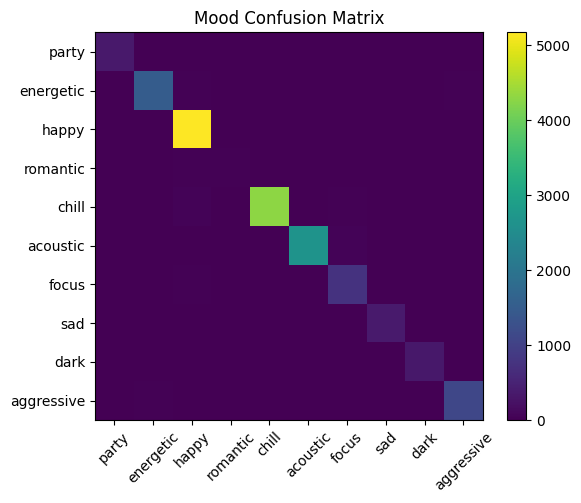

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Mood Confusion Matrix")
plt.xticks(range(len(MOODS)), MOODS, rotation=45)
plt.yticks(range(len(MOODS)), MOODS)
plt.colorbar()
plt.tight_layout()
plt.show()


## 9. Model Persistence

Save the trained model, scaler, and metadata for deployment and future use:
- **Model weights**: PyTorch state_dict for inference
- **Feature scaler**: StandardScaler for preprocessing new data
- **Mood mappings**: Encoding/decoding between mood names and indices
- **Model configuration**: Input dimensions, features, and architecture details

All artifacts are saved with timestamps for version control and easy model management.


In [21]:
import pickle
import os
from datetime import datetime
from pathlib import Path

# Define the Google Drive path (same as where data is loaded from)
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'
results_dir = os.path.join(drive_path, "mood_classifier_results")

# Create results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

# Generate timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model_path = os.path.join(results_dir, f"mood_classifier_{timestamp}.pt")
torch.save(model.state_dict(), model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = os.path.join(results_dir, f"feature_scaler_{timestamp}.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved to: {scaler_path}")

# Save mood mappings
mood_mappings = {
    'mood2id': mood2id,
    'id2mood': id2mood,
    'features': FEATURES,
    'moods': MOODS
}
mappings_path = os.path.join(results_dir, f"mood_mappings_{timestamp}.pkl")
with open(mappings_path, 'wb') as f:
    pickle.dump(mood_mappings, f)
print(f"✓ Mood mappings saved to: {mappings_path}")

# Save model configuration
config = {
    'input_dim': len(FEATURES),
    'num_classes': len(MOODS),
    'model_architecture': 'MoodNet',
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'features': FEATURES,
    'moods': MOODS,
    'timestamp': timestamp
}
config_path = os.path.join(results_dir, f"model_config_{timestamp}.pkl")
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"✓ Model configuration saved to: {config_path}")

print(f"\n{'='*60}")
print(f"Model training and saving complete!")
print(f"{'='*60}")
print(f"Google Drive directory: {results_dir}")
print(f"Timestamp: {timestamp}")
print(f"\nSaved files:")
print(f"  - {os.path.basename(model_path)}")
print(f"  - {os.path.basename(scaler_path)}")
print(f"  - {os.path.basename(mappings_path)}")
print(f"  - {os.path.basename(config_path)}")


✓ Model saved to: /content/drive/My Drive/Colab Notebooks/musix/mood_classifier_results/mood_classifier_20260219_064437.pt
✓ Scaler saved to: /content/drive/My Drive/Colab Notebooks/musix/mood_classifier_results/feature_scaler_20260219_064437.pkl
✓ Mood mappings saved to: /content/drive/My Drive/Colab Notebooks/musix/mood_classifier_results/mood_mappings_20260219_064437.pkl
✓ Model configuration saved to: /content/drive/My Drive/Colab Notebooks/musix/mood_classifier_results/model_config_20260219_064437.pkl

Model training and saving complete!
Google Drive directory: /content/drive/My Drive/Colab Notebooks/musix/mood_classifier_results
Timestamp: 20260219_064437

Saved files:
  - mood_classifier_20260219_064437.pt
  - feature_scaler_20260219_064437.pkl
  - mood_mappings_20260219_064437.pkl
  - model_config_20260219_064437.pkl
